In [26]:
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
training_set = pd.read_csv("dataset/train.csv")

In [13]:
training_set

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire
...,...,...
5978,image2494.jpg,Food
5979,image8015.jpg,Attire
5980,image4975.jpg,Food
5981,image1222.jpg,Food


In [14]:
training_imgs = ["{}".format(x) for x in list(training_set.Image)]

In [15]:
unique_classes = training_set['Class'].unique()
unique_classes

array(['Food', 'misc', 'Attire', 'Decorationandsignage'], dtype=object)

In [16]:
map_dict = {'Food':'0', 'misc':'1', 'Attire':'2', 'Decorationandsignage':'3'}
training_set['Class'] =training_set['Class'].map(map_dict)
training_set

,Image,Class
0,image7042.jpg,0
1,image3327.jpg,1
2,image10335.jpg,2
3,image8019.jpg,0
4,image2128.jpg,2
...,...,...
5978,image2494.jpg,0
5979,image8015.jpg,2
5980,image4975.jpg,0
5981,image1222.jpg,0


In [17]:
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
train_generator = train_dataGen.flow_from_dataframe(
                                        dataframe = training_set,
                                        directory="/home/etg-saibhargav/Documents/hackerearth/Gala images/dataset/Train Images",x_col="Image",
                                        y_col="Class", 
                                        class_mode="categorical",
                                        target_size=(128,128), 
                                        batch_size=100)
validation_dataGen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_dataGen.flow_from_dataframe(
                                        dataframe = training_set,
                                        directory="/home/etg-saibhargav/Documents/hackerearth/Gala images/dataset/Train Images",x_col="Image",
                                        y_col="Class", 
                                        class_mode="categorical",
                                        target_size=(128,128), 
                                        batch_size=100)

Found 5983 validated image filenames belonging to 4 classes.
Found 5983 validated image filenames belonging to 4 classes.


In [18]:
classifier = Sequential()

#First Convolutional layer
classifier.add(Conv2D(filters = 56,kernel_size = (4,4), activation = 'relu', input_shape = (128,128,3)))
classifier.add(MaxPooling2D(pool_size = (4,4)))

#second Convolutional layer
classifier.add(Conv2D(32,(4,4),activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (4,4)))

#Flattening
classifier.add(Flatten())
#Hidden Layer
classifier.add(Dense(units = 128, activation = 'relu'))

#Output Layer
classifier.add(Dense(units = 4 , activation = 'softmax'))

In [19]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 56)      2744      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 56)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        28704     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               200832    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                

In [20]:
from livelossplot.keras import PlotLossesCallback


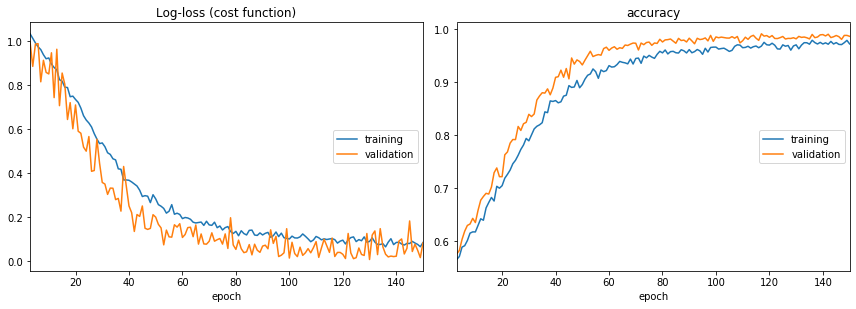

Log-loss (cost function):
training   (min:    0.066, max:    1.084, cur:    0.085)
validation (min:    0.008, max:    1.067, cur:    0.084)

accuracy:
training   (min:    0.536, max:    0.979, cur:    0.972)
validation (min:    0.539, max:    0.991, cur:    0.986)


In [22]:
classifier.fit_generator(train_generator, validation_data=validation_generator,epochs = 150, 
                         steps_per_epoch=len(train_generator.filenames) // 100,
                         validation_steps=len(train_generator.filenames) // 100,
                         callbacks=[PlotLossesCallback()] )

In [23]:

model_json = classifier.to_json()
with open('autotag_gala.json', 'w') as json_file:
    json_file.write(model_json)
classifier.save_weights("model_weights.h5")


In [1]:
from keras.models import model_from_json


Using TensorFlow backend.
/home/etg-saibhargav/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/etg-saibhargav/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/etg-saibhargav/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/etg-saibhargav/.local/lib/python3.6

In [2]:
json_file = open('autotag_gala.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_weights.h5")


In [3]:
reverse_map = {0:'Food', 1:'misc', 2:'Attire',3:'Decorationandsignage'}

In [7]:
test_generator.reset()
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        "/home/etg-saibhargav/Documents/hackerearth/galadataset/",
        target_size=(128, 128),class_mode="categorical",
        shuffle=False,batch_size=1)
pred=loaded_model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
pred

Found 3219 images belonging to 1 classes.
3219/3219 [==============================] - 11s 3ms/step


array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [8]:
filenames=test_generator.filenames
pred_values = []
i=0
for each in pred:
    
    #print(np.max(each))
    index = np.argwhere(each == np.max(each))[0][0]
    file_name = filenames[i].split('/')[1]
    i=i+1
    pred_values.append([file_name, reverse_map[index]])

In [9]:
df = pd.DataFrame(pred_values, columns=['Image', 'Class'])
df.head()

,Image,Class
0,image100.jpg,Attire
1,image10001.jpg,Food
2,image10005.jpg,Food
3,image10008.jpg,Attire
4,image10009.jpg,Attire


In [10]:
df.to_csv('submission.csv', index=False)
    